# Light curves with the W22 Model looking at Four Redder Supernovae and Investigating different Dust laws

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
import pandas as pd
from bayesn import SEDmodel

## Load the W22 Model

W22 model works with optical and NIR bands

In [2]:
model = SEDmodel(load_model='W22_model')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /root/partiiiproject
Loading built-in model W22_model
Loading built-in reddening law F99


## Generate Fits

We generate the fits for our supernova data.
We are looking at four different supernova:\
CSPDR3_2005A.PKMJD.DAT\
CSPDR3_2006br.PKMJD.DAT\
sn2009I.Wstd_snana.dat\
sn2006X.Wstd_snana.dat

In [3]:
supernova_file = "/root/partiiiproject/sn2006X.dat"
supernova_name = "sn2006X"
prior_distribution = "uniform"  #"uniform" "fixed" "normal2.5"
dust_law = "F99"
#mu_Rv_used = 2.5
drop_bands=['u_CSP']
sigma_R=0.5

In [4]:
#samples, sn_props = model.fit_from_file(supernova_file, mu_R=mu_Rv_used, sigma_R=sigma_R,drop_bands=drop_bands)
samples, sn_props = model.fit_from_file(supernova_file, RV='uniform', drop_bands=drop_bands, redlaw=dust_law, file_prefix = "DustLawsFitOfAllSamples/"+supernova_name + dust_law)
#redlaw=dust_law
#samples, sn_props = model.fit_from_file(supernova_file, drop_bands=drop_bands)

Loading built-in reddening law G23


/root/miniforge3/envs/bayesn/lib/python3.11/site-packages/jax/_src/linear_util.py:193: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          AV[0]      1.87      0.08      1.87      1.74      2.00      6.94      1.36
          Ds[0]     31.36      0.07     31.36     31.23     31.47      7.33      1.30
          RV[0]      1.49      0.09      1.49      1.34      1.63      5.93      1.42
 eps_tform[0,0]      3.71      0.47      3.71      2.95      4.52     46.76      1.08
 eps_tform[0,1]      0.08      0.25      0.08     -0.34      0.49    328.72      1.01
 eps_tform[0,2]      0.82      0.26      0.81      0.38      1.22      6.10      1.36
 eps_tform[0,3]     -1.63      0.13     -1.64     -1.86     -1.42     82.89      1.04
 eps_tform[0,4]      3.19      0.15      3.18      2.94      3.45     15.61      1.14
 eps_tform[0,5]     -1.02      0.86     -1.19     -2.33      0.31     13.92      1.21
 eps_tform[0,6]      1.38      0.21      1.38      1.09      1.77      6.96      1.30
 eps_tform[0,7]      0.22      0.18      0.21     -0.

## Load Observational Data

We read the observational data andits assosciated uncertainty 

In [5]:
meta, lcdata = sncosmo.read_snana_ascii(supernova_file, default_tablename='OBS')
lcdata = lcdata['OBS'].to_pandas()

In [6]:
dust_law= 'G23'
z = meta['REDSHIFT_FINAL']
ebv_mw = meta['MWEBV']
sampleChainsDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_chains.pkl"
sampleSummaryDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_fit_summary.csv"
samplesSummary = pd.read_csv(sampleSummaryDir)
samplesSummary = samplesSummary.rename(index=samplesSummary['Unnamed: 0'])
t = np.arange(-15, 100, 1)
bands = ['g_CSP', 'r_CSP', 'i_CSP', 'B_CSP', 'V_CSP', 'Y_RC', 'J_RC1', 'H_RC'] 
flux_grid = model.get_flux_from_chains(t, bands, sampleChainsDir, z, ebv_mw, mag=False, num_samples=10)
fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))

Getting best fit light curves from chains...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


## Use chains to get Fits to plot

Choose the bands we want to plot and the number of days on either side of the peak.

In [7]:
t = np.arange(-15, 100, 1) #Days on either side of the peak  normally (-15,40)
bands = ['g_CSP', 'r_CSP', 'i_CSP', 'B_CSP', 'V_CSP', 'Y_RC', 'J_RC1', 'H_RC'] #Bands being used for plot
#z, ebv_mw = sn_props
#flux_grid = model.get_flux_from_chains(t, bands, samples, z, ebv_mw, mag=False, num_samples=10)

Turn the flux into an actual fit we can plot

In [8]:
fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))

## Plot a graph

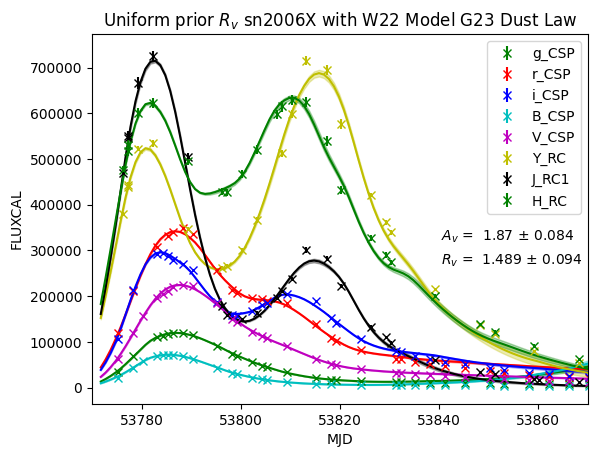

In [9]:
cs = ['g', 'r', 'b', 'c', 'm', 'y', 'k','g']
plot_t = t + meta['SEARCH_PEAKMJD']
for b_ind, b in enumerate(bands):
    b_data = lcdata[lcdata.FLT == b]
    plt.errorbar(b_data.MJD, b_data.FLUXCAL, b_data.FLUXCALERR, fmt=f'{cs[b_ind]}x', label=b)
    plt.plot(plot_t, fit[b_ind, :], color=cs[b_ind])
    plt.fill_between(plot_t, fit[b_ind, :] - fit_err[b_ind, :], fit[b_ind, :] + fit_err[b_ind, :], alpha=0.3, color=cs[b_ind])
plt.title(rf'Uniform prior $R_v$ '+supernova_name+' with W22 Model ' + dust_law +' Dust Law')
plt.xlabel('MJD')
plt.ylabel('FLUXCAL')
plt.xlim(53770,53870)
plt.legend()
#plt.figtext(1, .45, "Prior mean_Rv = " + str(mu_Rv_used))
#plt.figtext(1, .4, "Prior std_Rv = " + str(sigma_R))
plt.figtext(0.67, .45, rf"$A_v$ =  {samplesSummary.loc['AV[0]', 'mean']} $\pm$ {samplesSummary.loc['AV[0]', 'sd']}")
#plt.figtext(0.55, .75, rf"Std $A_v$ =  {np.std(samples['AV']):.2f}")
plt.figtext(0.67, .40, rf"$R_v$ =  {samplesSummary.loc['RV[0]', 'mean']} $\pm$ {samplesSummary.loc['RV[0]', 'sd']}")
#plt.figtext(0.55, .65, rf"Std $R_v$ =  {np.std(samples['RV']):.2f}")
plt.savefig("/root/partiiiproject/DustLawsW22Graphs/"+supernova_name+prior_distribution+dust_law+".png", bbox_inches='tight') #save plot
#plt.savefig("/root/partiiiproject/RedderLightCurvesUniformW22Graphs/"+supernova_name+"Fixed.png", bbox_inches='tight')
plt.show()

Plotted as Sub-Plots

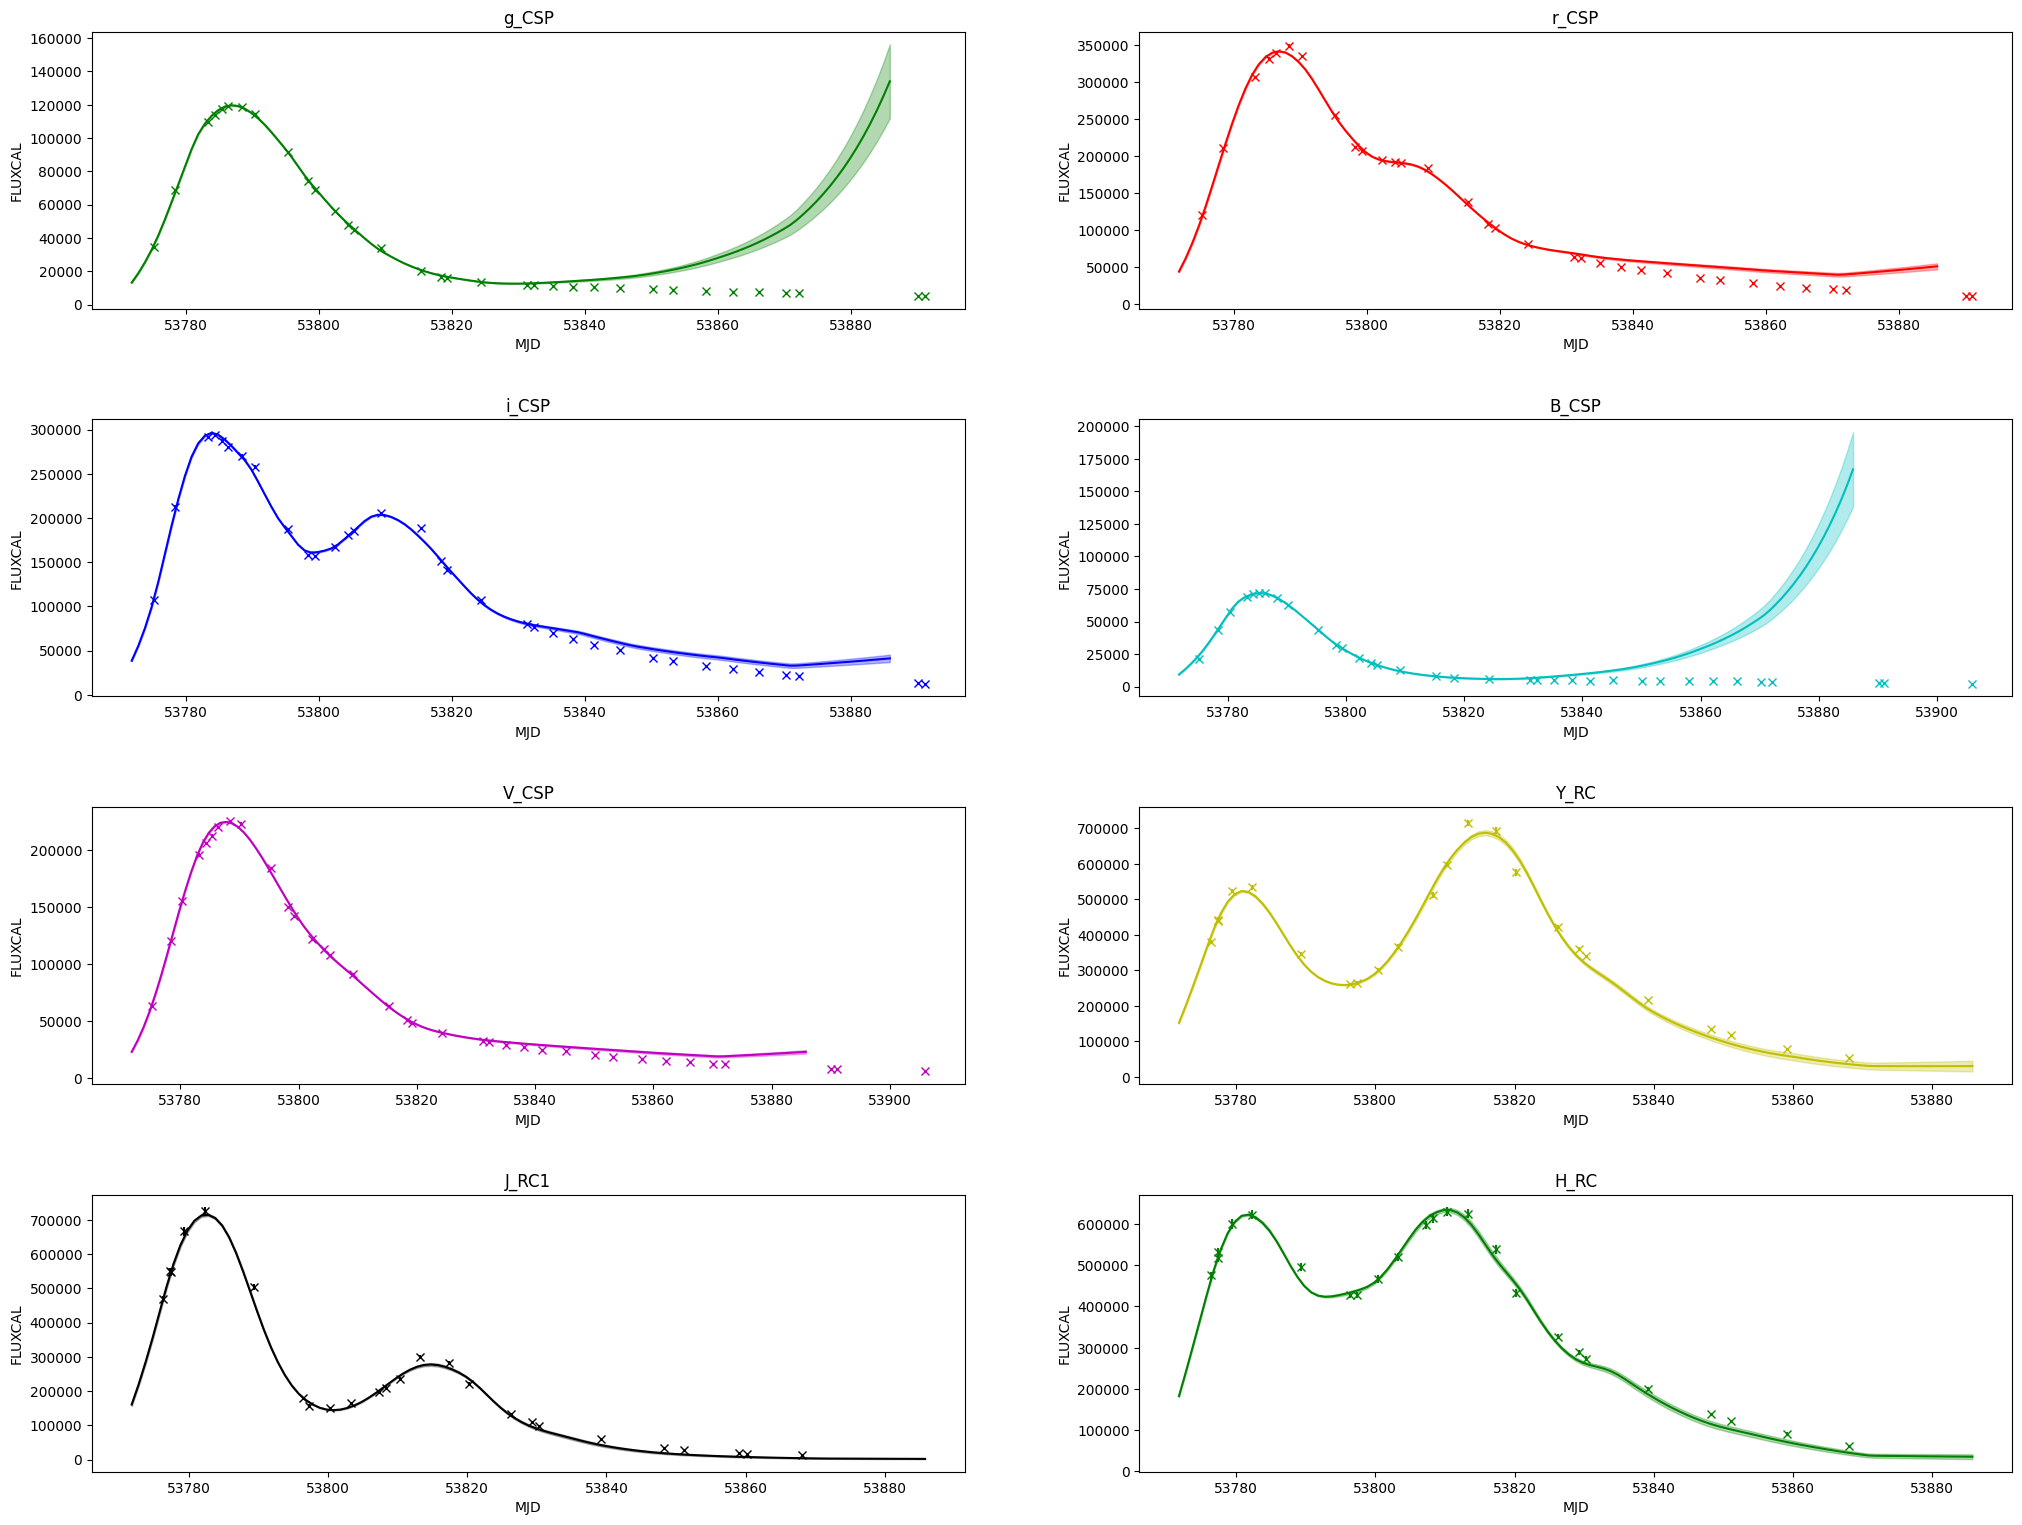

In [10]:
cs = ['g', 'r', 'b', 'c', 'm', 'y', 'k','g'] #colour scheme
plot_t = t + meta['SEARCH_PEAKMJD'] #Time is based around the peak for the supernova
figure, axis = plt.subplots(4, 2) #Sub plots 3 rows and 2 columns
for b_ind, b in enumerate(bands): #Loop through the bands given
    b_data = lcdata[lcdata.FLT == b] #get the original data for the band (previous method took first character!)
    axis[b_ind//2, b_ind%2].errorbar(b_data.MJD, b_data.FLUXCAL, b_data.FLUXCALERR, fmt=f'{cs[b_ind]}x', label=b)
    axis[b_ind//2, b_ind%2].plot(plot_t, fit[b_ind, :], color=cs[b_ind])
    axis[b_ind//2, b_ind%2].fill_between(plot_t, fit[b_ind, :] - fit_err[b_ind, :], fit[b_ind, :] + fit_err[b_ind, :], alpha=0.3, color=cs[b_ind])
    axis[b_ind//2, b_ind%2].set_title(b)
    axis[b_ind//2, b_ind%2].set_xlabel('MJD')
    axis[b_ind//2, b_ind%2].set_ylabel('FLUXCAL')
#axis.legend()
plt.subplots_adjust(left=0, right=3, bottom=0, top=3, wspace=0.2, hspace=0.4)
figure.show()

## Saving the plot to a file

Saving Sub Plot

In [11]:
figure.savefig("/root/partiiiproject/DustLawsW22Graphs/"+supernova_name+prior_distribution+dust_law+"Combined.png", bbox_inches='tight')

## A little look at Dust Values

(array([  3.,   7.,  60., 153., 194., 216., 182., 117.,  47.,  21.]),
 array([1.60304648, 1.65227248, 1.70149848, 1.75072448, 1.79995048,
        1.84917648, 1.89840248, 1.94762848, 1.99685448, 2.04608048,
        2.09530648]),
 <BarContainer object of 10 artists>)

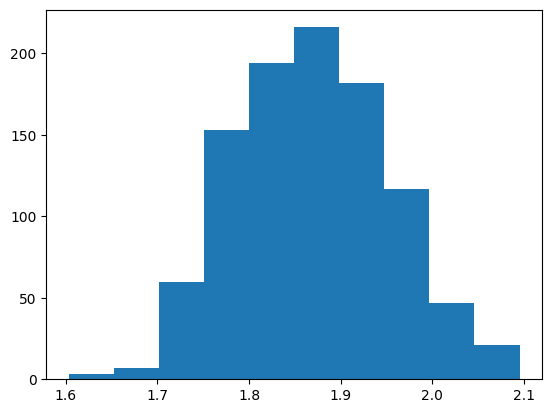

In [12]:
plt.hist(samples['AV'].flatten())

In [13]:
np.mean(samples['AV'])

Array(1.87028366, dtype=float64)

In [14]:
np.std(samples['AV'])

Array(0.08376323, dtype=float64)

In [15]:
np.mean(samples['theta'])

Array(-0.01402262, dtype=float64)

In [16]:
mu = np.mean(samples['mu'])
print(10**(mu/5-5))

18.688300634284637
